In [17]:
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import xgboost as xgb
# from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import os
import matplotlib.pyplot as plt
import random
import torch

In [24]:
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor,
                              StackingRegressor, VotingRegressor)

In [3]:
yc_access_key = os.getenv('YC_ACCESS_KEY')
yc_secret_key = os.getenv('YC_SECRET_KEY')
bucket_name = 'otus-fin'
endpoint_url = 'https://storage.yandexcloud.net'

In [9]:
df = pd.read_parquet(
                        f's3://otus-fin/data/train_features/ADAUSDT.parquet',
                        engine='pyarrow',
                        storage_options={
                            'key': yc_access_key,
                            'secret': yc_secret_key,
                            'client_kwargs': {'endpoint_url': endpoint_url}
                        }
                    )

In [5]:
df.tail()

,open,high,low,close,volume,price_change,next_log_return,high_low_spread,close_open_spread,volume_change,...,rolling_max_10,rolling_min_10,rolling_mean_20,rolling_max_20,rolling_min_20,Skew_20,kurtosis_20,zscore_20,day_of_week,hour_of_day
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-19 10:30:00,0.7426,0.7426,0.7389,0.7391,1136409.0,-0.0035,-0.004724,0.0037,-0.0035,564054.0,...,0.7449,0.7391,0.744315,0.7533,0.7391,0.955425,-0.423500,-1.165703,1,10
2024-11-19 10:35:00,0.7391,0.7410,0.7387,0.7400,742084.0,0.0009,0.001217,0.0023,0.0009,-394325.0,...,0.7449,0.7391,0.743690,0.7533,0.7391,1.214970,0.468305,-0.889612,1,10
2024-11-19 10:40:00,0.7400,0.7407,0.7373,0.7400,1006101.0,0.0000,0.000000,0.0034,0.0000,264017.0,...,0.7449,0.7391,0.743025,0.7522,0.7391,1.392364,1.339101,-0.844658,1,10
2024-11-19 10:45:00,0.7400,0.7417,0.7394,0.7406,551786.0,0.0006,0.000810,0.0023,0.0006,-454315.0,...,0.7449,0.7391,0.742445,0.7507,0.7391,1.502738,2.247215,-0.630056,1,10
2024-11-19 10:50:00,0.7406,0.7420,0.7401,0.7403,374828.0,-0.0003,-0.000405,0.0019,-0.0003,-176958.0,...,0.7449,0.7391,0.741925,0.7486,0.7391,1.339475,2.245661,-0.717647,1,10


In [10]:
df = df[['open', 'high', 'low', 'close', 'volume', 'rolling_mean_10', 'rolling_min_5', 'rolling_min_20', 'rolling_min_10', 'rolling_max_20', 'rolling_max_10']]

In [11]:
df['target'] = df['close'].shift(-1)

In [7]:
# df = df.drop(columns=['support_line', 'resistance_line', 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b'])

In [12]:
df = df.dropna()

In [20]:
X = df.drop(columns=['target'])  # Замените 'target_column' на название целевой переменной
y = df['target']

In [21]:
train_size = 0.95  # 95% для тренировки

# Определяем индекс для разбиения
split_index = int(len(df) * train_size)

# Тренировочные данные: первые 70% данных
X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]

# Тестовые данные: оставшиеся 30% данных
X_val, y_val = X.iloc[split_index:], y.iloc[split_index:]

In [18]:
SEED = 777
def seed_everything(seed: int = 42) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    print(f"Using {seed} seed")

In [19]:
seed_everything(SEED)

Using 777 seed


### Использую ансамбль из простых моделей
*рендом форест убрал, так как у меня с ним зависает ноутбук, а какчестов предсказание он не особо бустит  

In [34]:
model1 = LinearRegression()
# model2 = RandomForestRegressor(n_estimators=50, random_state=SEED)
model3 = GradientBoostingRegressor(n_estimators=100, random_state=SEED)

In [35]:
voting_clf = VotingRegressor(estimators=[
    ('lr', model1),
    # ('rf', model2),
    ('gb', model3)])

In [29]:
y_train.values

array([1.3174, 1.3156, 1.3222, ..., 0.3553, 0.3556, 0.3559], dtype=float32)

In [36]:
voting_clf.fit(X_train, y_train.values)
y_pred = voting_clf.predict(X_val)

In [37]:
y_pred0 = voting_clf.estimators_[0].predict(X_val)
y_pred1 = voting_clf.estimators_[1].predict(X_val)

In [41]:
print(f"""
MAE of {voting_clf.estimators_[0]}: {mean_absolute_error(y_val,y_pred0):.4f} , R²: {r2_score(y_val, y_pred0)}
MAE of {voting_clf.estimators_[1]}: {mean_absolute_error(y_val, y_pred1):.4f}, R²: {r2_score(y_val, y_pred1)}
MAE of Voting Classifier : {mean_absolute_error(y_val, y_pred):.4f} , R²: {r2_score(y_val, y_pred)}
""".strip())

MAE of LinearRegression(): 0.0013 , R²: 0.9994528293609619
MAE of GradientBoostingRegressor(random_state=777): 0.0024, R²: 0.9991428079316163
MAE of Voting Classifier : 0.0015 , R²: 0.9995271907888095


### Добавлю в ансамбль показания индикаторов и запущу бэктекст

In [42]:
import ccxt

In [43]:
def get_dates():
    current_time = datetime.utcnow()
    # Округляем до 5 минут в меньшую сторону
    rounded_time = (current_time - timedelta(minutes=current_time.minute % 5,
                                            seconds=current_time.second,
                                            microseconds=current_time.microsecond))
       
    return "2024-11-19T10:50:00Z", rounded_time.strftime('%Y-%m-%dT%H:%M:%SZ')

In [44]:
def get_newdata(symbol, exchange='bybit', timeframe='5m'):
    
    start_date, end_date = get_dates()
    
    object_name = f'{end_date}.parquet'
    '''
    загрузка данных с пом библ ccxt
    по умолчанию лимит 1000 баров, пока подстроенно для 5минутных таймфреймов по 3 дня 
    
    '''
    if exchange == 'bybit':
        exchange = ccxt.bybit()  # Можно использовать любую биржу, которая поддерживается ccxt

    start_date = exchange.parse8601(start_date)  # Укажите начальную дату и время в формате ISO 8601
    end_date = exchange.parse8601(end_date)
    if not start_date or not end_date:
        logging.info(f"Неправильные даты")
        return

    # if len(symbols) == 0:
    #     logging.info(f"Нет тикерв")
    #     return

    since = start_date
    
    dfs = []
    since = start_date
    while since < end_date:
        try:                
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=864) # 864 - 3 дня по 24 часа по 5 минут
        except Exception as e:
            logging.error(f"Ошибка при обработке символа {symbol}: {e}")
            break
            
        since = ohlcv[-1][0]  + 300000 # это 5 минут

        df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        # df.set_index('timestamp', inplace=True)
        dfs.append(df)
        time.sleep(0.2)
    
    df_ticker = pd.concat(dfs, ignore_index=True)
    df_ticker.set_index('datetime', inplace=True)        
    df_ticker.dropna(inplace=True)

    return df_ticker
        

In [45]:
def analytics(results, coin):
    sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()
    trades = results[0].analyzers.trades.get_analysis()
    returns = results[0].analyzers.returns.get_analysis()

    name_strategy = results[0].__class__.__name__

    try:
        wons = trades.won.total
    except:
        wons = 0

    try:
        loses = trades.lost.total
    except:
        loses = 0    
    try:
        won_longest = trades.streak.won.longest
    except:
        won_longest = 0 
    
    try:
        lost_longest = trades.streak.lost.longest
    except:
        lost_longest = 0 

    try:
        won_max = trades.won.pnl.max
    except:
        won_max = 0

    try:
        lost_max = trades.lost.pnl.max
    except:
        lost_max = 0 
    try:
        gross = round(trades.pnl.gross.total, 3)
    except:
        gross = 0 
    try:
        net = round(trades.pnl.net.total, 3)
    except:
        net = 0 
        
    res = {
            "Стратегия" : name_strategy,
            "Монет" : coin,
            "Общая доходность": round(returns['rtot']*100, 3),
            "Год норм дох-ть": round(returns['rnorm100'], 3),
            "Макс просадка %": round(drawdown.max.drawdown, 3),
            "Макс просадка $": round(drawdown.max.moneydown, 3),
            "Кол-во сделок": trades.total.total,
            "Кол-во прибыльных": wons,
            "Кол-во убыточных": loses,
            "Винрейт": round(wons / (trades.total.total+0.0001) * 100, 3),
            "Серия выигранных сд": won_longest,
            "Серия проигранных сд": lost_longest,
            "Макс. прибыль в 1 сд": round(won_max, 3),
            "Макс. убыток в 1 сд": round(lost_max, 3),
            "Gross": gross,
            "Net": net
    
     }
    return pd.DataFrame([res])

In [46]:
testdf = get_newdata("ADAUSDT")

/tmp/ipykernel_51785/1847871257.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


In [47]:
from feature_engineering import Features

In [48]:
f_shape_pl = ['open', 'high', 'low', 'close', 'volume', 'rolling_mean_10', 'rolling_min_5', 'rolling_min_20', 'rolling_min_10', 'rolling_max_20', 'rolling_max_10'] 

In [52]:
f_shape = ['close', 'rolling_mean_10', 'rolling_min_5', 'high', 'rolling_min_20', 'rolling_min_10', 'rolling_max_20', 'rolling_max_10', 'open' ]

In [49]:
df_features = testdf.copy()

feature_engineer = Features(df_features)

In [50]:
df_features = feature_engineer.lag_rolling_features(lags=[1, 2, 3], windows=[5, 10, 20])
df_features = feature_engineer.fill(True, True)
df_features = df_features.dropna()

In [51]:
df_features = df_features[f_shape_pl]

In [53]:
new_pred = voting_clf.predict(df_features[f_shape_pl])

In [54]:
df_features['predict'] = new_pred

In [55]:
import backtrader as bt

In [56]:
class PandasDataExtend(bt.feeds.PandasData):
    # Добавляем новый столбец с данными о биткоине
    lines = ('predict',)  # Имя новой линии данных

    # Определяем параметры, которые соответствуют колонкам в DataFrame
    params = (
        ('predict', -1),  # Значение -1 означает, что столбец с данными 'btc_close' нужно найти в DataFrame
    )

class MyStrategy1(bt.Strategy):
    '''
    Стратегия работает на 5-минутом интеравле криптовалют.
    Вход - при условие что зафиксирован тренд вниз, с помощью SMA-95, я пытаюсь угадать разворот, с помощью предсказания
    '''
    params = (
        ('maperiod', 13),
        ('maperiod_long', 95),
    )
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datalow = self.datas[0].low
        self.datahigh = self.datas[0].high
        self.datapredict = self.datas[0].predict
        # self.datalow = self.datas[0].low
        self.order = None
        self.stop_order = None
        self.buyprice = None
        self.buycomm = None
        self.stop_price = None
        self.pos = None

        cash = self.broker.get_cash()
        amount_to_invest = cash * 0.5
        self.size = int(amount_to_invest // self.dataclose[0])

        #Сигналы
        self.trend = 0
        self.rsi_signal = 0

        # Индикаторы
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        self.sma_long = bt.indicators.SimpleMovingAverage(
             self.datas[0], period=self.params.maperiod_long)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))        

    def next(self):
        # self.log('Close, %.2f, Close, %.' % (self.dataclose[0], self.norm_macd(self.macd[0])))
        self.log(f"Close, {self.dataclose[0]}")   
        self.locallow = min(self.datas[0].low[i] for i in range(-7, 0))
        
        # Проверяем сигналы тренда

        if self.order:
            return

        if not self.position:
            if self.dataclose[-1] < self.sma_long[-1]:
                if (self.dataclose[0] > self.dataclose[-1]) & (self.datapredict[0] > self.dataclose[0]):
                # if self.datapredict[0] > self.datahigh[0]:
                    self.log('BUY CREATE, %.2f, Vol, %.2f' % (self.dataclose[0], self.size))
                    self.order = self.buy(size=self.size) #
                    # self.locallow = min(self.datas[0].low[i] for i in range(-7, 0))
                    self.stop_price = self.locallow * 0.9999 #self.datalow[0] * 0.9999
                    self.stop_order = self.sell(exectype=bt.Order.Stop, price=self.stop_price, size=self.size) #
                    self.log('STOP-LOSS, %.2f' % self.stop_price)
                    self.take_profit_price = self.dataclose[0] * 1.3
                    

        else:
            if self.data.close[0] >= self.take_profit_price:
                self.log('SELL CREATE!, %.2f' % self.dataclose[0])
                self.order = self.sell(size=self.size)
                self.cancel(self.stop_order) 
 

Starting Portfolio Value: 5000.00
2024-11-19, Close, 0.736299991607666
2024-11-19, Close, 0.7376999855041504
2024-11-19, Close, 0.7416999936103821
2024-11-19, Close, 0.7443000078201294
2024-11-19, Close, 0.7386000156402588
2024-11-19, Close, 0.7429999709129333
2024-11-19, Close, 0.7462000250816345
2024-11-19, Close, 0.7491999864578247
2024-11-19, Close, 0.7502999901771545
2024-11-19, Close, 0.7480999827384949
2024-11-19, Close, 0.7457000017166138
2024-11-19, Close, 0.7494999766349792
2024-11-19, Close, 0.7497000098228455
2024-11-19, Close, 0.7497000098228455
2024-11-19, Close, 0.7498000264167786
2024-11-19, Close, 0.7473000288009644
2024-11-19, Close, 0.7526000142097473
2024-11-19, Close, 0.7585999965667725
2024-11-19, Close, 0.7616999745368958
2024-11-19, Close, 0.7580000162124634
2024-11-19, Close, 0.7551000118255615
2024-11-19, Close, 0.7578999996185303
2024-11-19, Close, 0.7534000277519226
2024-11-19, Close, 0.7545999884605408
2024-11-19, Close, 0.7574999928474426
2024-11-19, Close

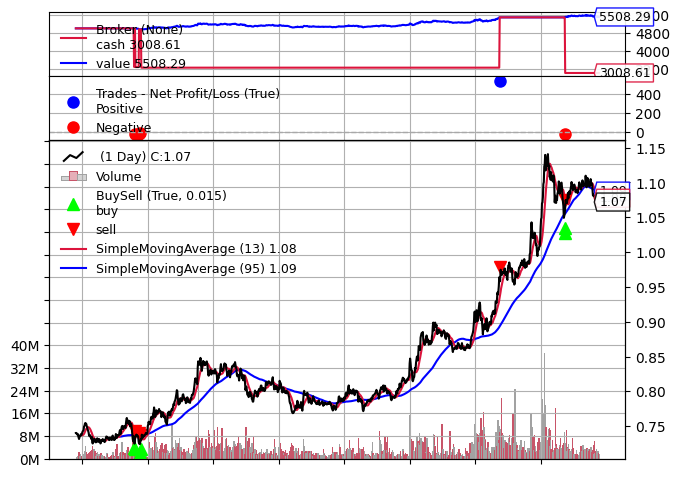

[[<Figure size 640x480 with 4 Axes>]]

In [57]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy1) #, maperiod=10, maperiod_long=95

data = df_features[['open', 'high', 'low', 'close', 'volume', 'predict']]
data_feed = PandasDataExtend(dataname=data)
# data_feed = PandasDataExtend(dataname=DASH)
# Add the Data Feed to Cerebro
cerebro.adddata(data_feed)
# cerebro.addsizer(bt.sizers.FixedSize, stake=100)

# Set our desired cash start
cerebro.broker.setcash(5000.0)
cerebro.broker.setcommission(commission=0.001)

#Аналитика
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
# cerebro.run()
results = cerebro.run()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Вывод метрик
%matplotlib inline
cerebro.plot(iplot=False)

In [58]:
analytics(results,'ADAUSDT')

,Стратегия,Монет,Общая доходность,Год норм дох-ть,Макс просадка %,Макс просадка $,Кол-во сделок,Кол-во прибыльных,Кол-во убыточных,Винрейт,Серия выигранных сд,Серия проигранных сд,Макс. прибыль в 1 сд,Макс. убыток в 1 сд,Gross,Net
0,MyStrategy1,ADAUSDT,9.682,13056.517,3.545,185.161,6,1,4,16.666,1,3,537.77,-22.471,491.767,472.736


### Вывод
Я использовал лёгкие и быстроые модели для предсказания цены в небольшом ансамбле, потом эти предсказания  
применил в торговой стратегии в сочетании с показателями индикаторов и получил неплохую прибыль